In [ ]:
# !pip install rdkit catboost
# !python -m pip install git+https://github.com/EBjerrum/molvecgen

In [5]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import cross_val_score
from molvecgen.vectorizers import SmilesVectorizer

In [7]:
import numpy as np
import pandas as pd
import sys, os
# sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/mol2vec')
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

In [91]:
df = pd.read_excel('1400.xlsx')
df = df.drop(columns = 'Pictures')
df['SI'] = df['CC50-MDCK, mmg/ml']/df['IC50, mmg/ml']
df['S_leng'] = df['SMILES'].str.len()

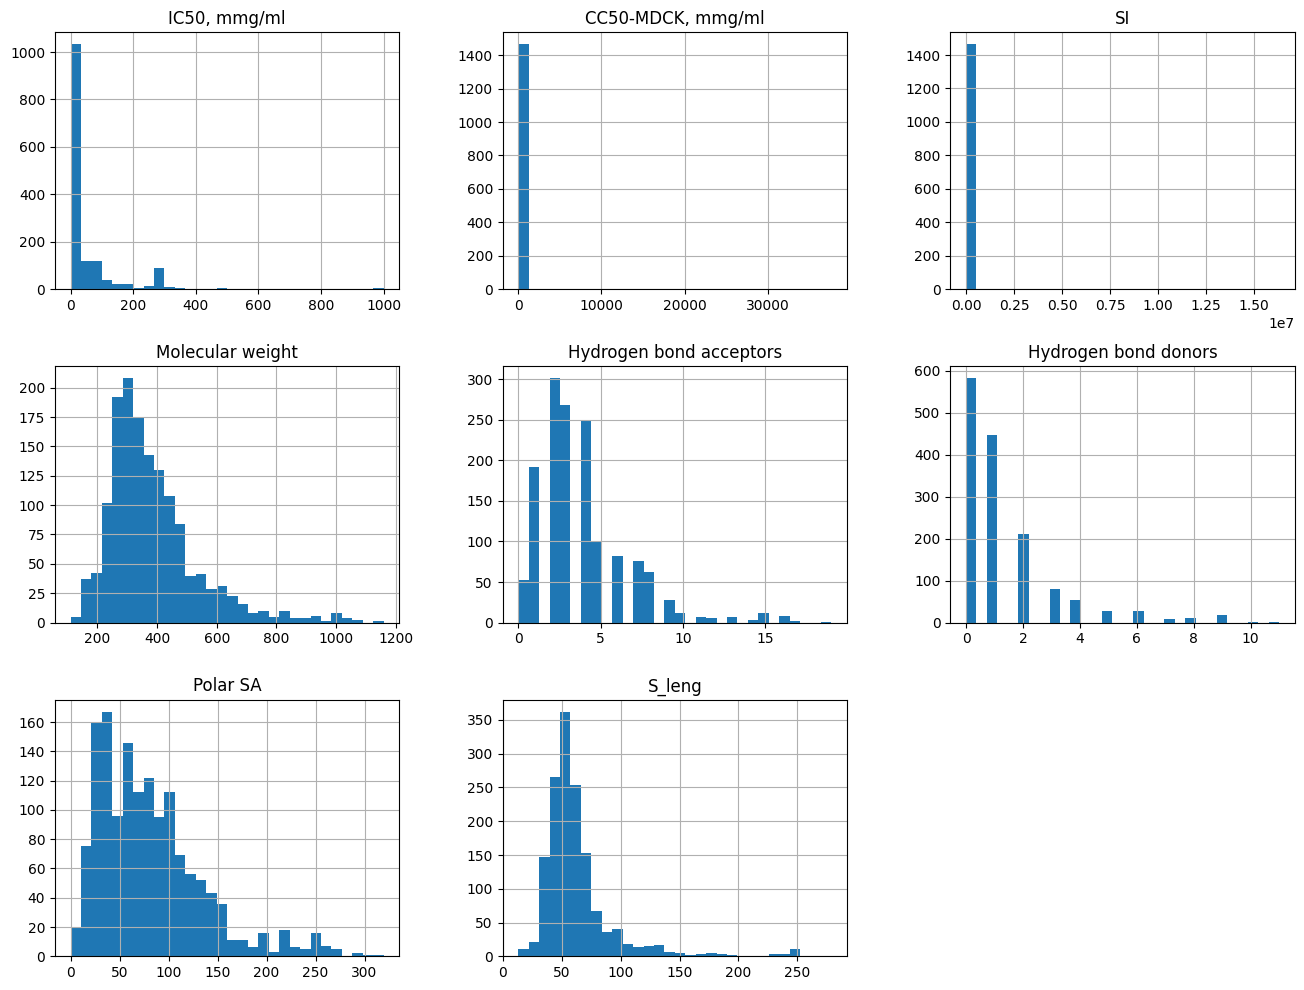

In [92]:
df.hist(bins=30, figsize=(16, 12))
plt.show()

In [93]:
# проверяем пропуски
df.isna().sum().sum()

0

In [94]:
# проверка полных дубликатов
df[df.duplicated()]

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,S_leng
35,1068-As-109,16.5,500.0,30.303030,197.323,1,1,32.26,OCCN[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,36
39,1072-Ch-4,335.0,500.0,1.492537,152.238,1,0,17.07,C1C[C@H](C2)C(C)(C)C(=O)[C@@]12C,32
46,1079-Ya-230,1.3,49.0,37.692308,250.431,1,0,38.38,NCCCCCC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,39
54,1327-As-120-7,27.3,500.0,18.315018,237.412,1,0,12.36,C[N+](C)(C)CC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,45
58,1330-Ya-250,36.2,500.0,13.812155,251.439,1,0,12.36,C[N+](C)(C)CCC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,46
120,1483-As-190,4.0,63.0,15.750000,153.270,0,0,26.02,C[C@@]12C(C)(C)[C@H](CC2)C[C@@H]1N,34
123,1485-Ya-339-6,3.6,7.0,1.944444,317.478,1,0,12.36,c1ccccc1C(c2ccccc2)\N=C\3C[C@@H](CC4)C(C)(C)[C...,52
453,4787-NNA-121,170.0,300.0,1.764706,392.226,2,0,27.05,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)c1cc(OC)n(n1)-c2c...,51
461,4794-KUD-301,10.0,10.6,1.060000,345.324,2,3,97.19,FC(F)(F)c1cc([nH]n1)C(\C)=N\NC(=S)Nc2ccc(F)cc2,46


In [95]:
# проверка дубликатов по названию
df[df.duplicated(subset='Title', keep=False)]

,Title,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,SMILES,S_leng
0,1007-Ya-213,2.7,500.0,185.185185,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,35
1,1007-Ya-213,0.7,447.0,638.571429,195.307,2,1,32.59,OCC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,35
10,1016-As-104,5.1,500.0,98.039216,613.079,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,100
11,1016-As-104,113.0,404.0,3.575221,613.079,2,0,24.72,CC1(C)[C@H](CC2)CC(\[C@@]12C)=N\CC[N+](CC)(CC)...,100
29,1062-TX-2330,300.0,300.0,1.000000,266.171,4,0,145.02,CS(=O)c(n1)nn(c12)c(=O)c([N+]([O-])=O)nn2[Na],45
30,1062-TX-2330,6.7,500.0,74.626866,266.171,4,0,145.02,CS(=O)c(n1)nn(c12)c(=O)c([N+]([O-])=O)nn2[Na],45
34,1068-As-109,16.5,500.0,30.303030,197.323,1,1,32.26,OCCN[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,36
35,1068-As-109,16.5,500.0,30.303030,197.323,1,1,32.26,OCCN[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,36
37,1072-Ch-4,5.0,500.0,100.000000,152.238,1,0,17.07,C1C[C@H](C2)C(C)(C)C(=O)[C@@]12C,32
38,1072-Ch-4,335.0,500.0,1.492537,152.238,1,0,17.07,C1C[C@H](C2)C(C)(C)C(=O)[C@@]12C,32


In [96]:
# Обработка дубликатов
df['finger'] = df['SMILES'].apply(lambda x: AllChem.RDKFingerprint(Chem.MolFromSmiles(x)))
duplicates = df[df.duplicated(subset='Title', keep='first')]

for i in range(len(duplicates)):
  distances = []
  fps_1 = duplicates.iloc[i]['finger']
  for j in range(len(df)):
    fps_2 = df.iloc[j]['finger']
    if fps_1 != fps_2:
      dist = DataStructs.FingerprintSimilarity(fps_1, fps_2)
      distances.append(dist)
  duplicates.loc[duplicates.index[i], 'IC50, mmg/ml'] = df.iloc[np.argmax(distances)]['IC50, mmg/ml']
  duplicates.loc[duplicates.index[i], 'CC50-MDCK, mmg/ml'] = df.iloc[np.argmax(distances)]['CC50-MDCK, mmg/ml']
  duplicates.loc[duplicates.index[i], 'SI'] = df.iloc[np.argmax(distances)]['SI']
df.drop_duplicates(subset='Title', keep=False, inplace=True)
df = pd.concat([df, duplicates]).drop('finger', axis=1)

[10:13:36] Conflicting single bond directions around double bond at index 55.
[10:13:36]   BondStereo set to STEREONONE and single bond directions set to NONE.


In [97]:
# Фильтрация DataFrame, по графикам
df = df[(df['SI'] < 100) & (df['Polar SA'] < 300) & (df['Molecular weight'] < 1000) & (df['S_leng'] < 200)]

In [98]:
df.describe()

,"IC50, mmg/ml","CC50-MDCK, mmg/ml",SI,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000
mean,57.528413,147.930767,12.038845,373.385287,3.583333,1.146032,74.927548,59.594444
std,96.532874,143.249175,18.020193,134.757431,2.489095,1.534131,47.669662,23.910572
min,0.004219,0.031928,0.036161,110.157000,0.000000,0.000000,0.000000,13.000000
25%,4.400000,30.275000,1.568424,281.059500,2.000000,0.000000,39.440000,46.000000
50%,14.400000,90.400000,3.987342,344.498500,3.000000,1.000000,66.760000,54.000000
75%,66.200000,300.000000,13.621472,431.790750,4.000000,2.000000,99.330000,66.000000
max,1000.000000,1039.000000,99.000000,923.347000,17.000000,11.000000,296.980000,195.000000


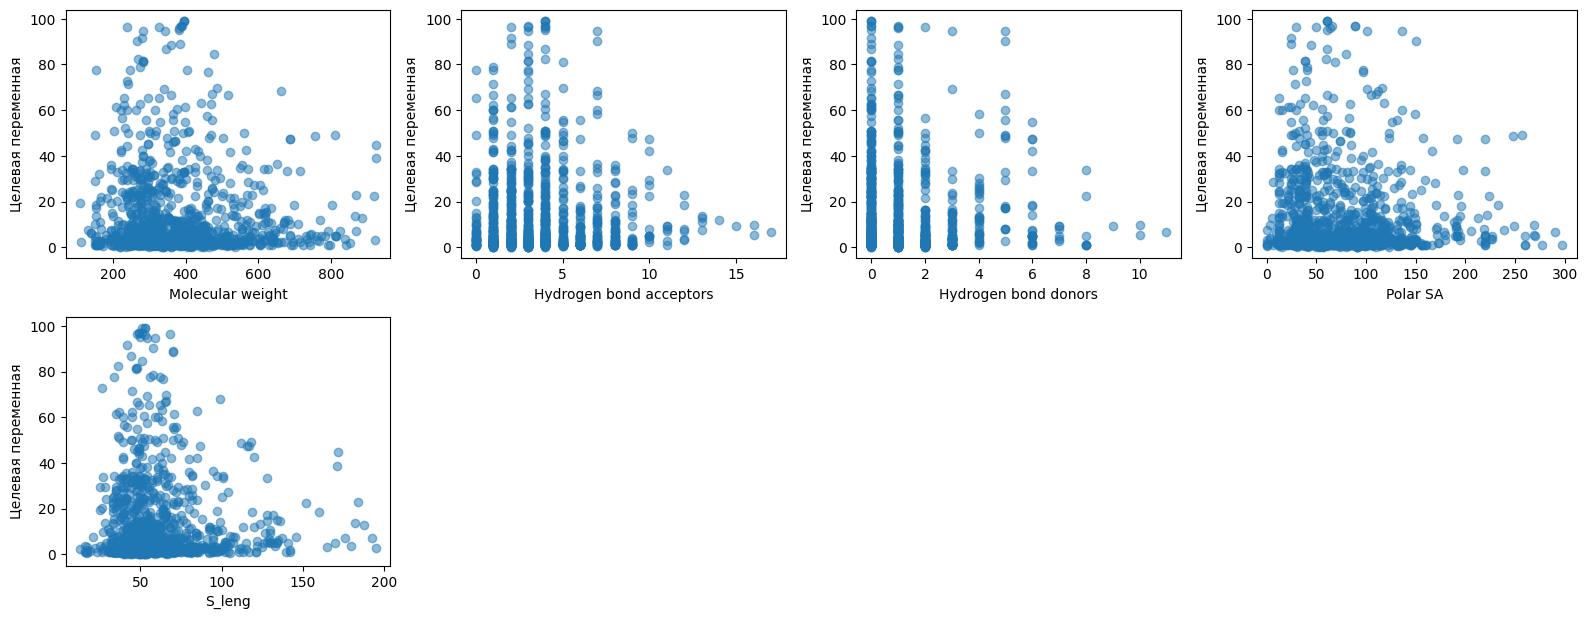

In [80]:
plt.figure(figsize=(16, 12))
features = df.drop(columns=['Title', 'SMILES', 'IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI']).columns

for i, feature in enumerate(features):
    plt.subplot(4, 4, i + 1)
    plt.scatter(df[feature], df['SI'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Целевая переменная')

plt.tight_layout()
plt.show()

In [36]:
# вспомогательные таблицы для smiles
df_w = df[['IC50, mmg/ml', 'SMILES']]
df_v = df[['IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Molecular weight',
       'Hydrogen bond acceptors', 'Hydrogen bond donors', 'Polar SA', 'S_leng']]
PandasTools.AddMoleculeColumnToFrame(df_w,'SMILES','Molecule')
df_w[["SMILES","Molecule"]]

/usr/local/lib/python3.10/dist-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,SMILES,Molecule
2,CCN(CC)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7f2163cd33e0>
3,CN(C)CC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7f2163cd3370>
4,CN(C)CC(=O)O[C@H]1C[C@H](CC2)C(C)(C)[C@@]12C,<rdkit.Chem.rdchem.Mol object at 0x7f2163cd3290>
5,CC[N+](C)(CC)CC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7f2163cd3220>
6,CC[N+](CC)(CC)CC\N=C(\[C@]12C)C[C@@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7f2163cd31b0>
...,...,...
58,C[N+](C)(C)CCC\N=C(\[C@@]12C)C[C@H](C1(C)C)CC2,<rdkit.Chem.rdchem.Mol object at 0x7f215f085540>
120,C[C@@]12C(C)(C)[C@H](CC2)C[C@@H]1N,<rdkit.Chem.rdchem.Mol object at 0x7f215f0855b0>
123,c1ccccc1C(c2ccccc2)\N=C\3C[C@@H](CC4)C(C)(C)[C...,<rdkit.Chem.rdchem.Mol object at 0x7f215f085620>
453,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)c1cc(OC)n(n1)-c2c...,<rdkit.Chem.rdchem.Mol object at 0x7f215f085690>


In [37]:
smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(df_w.Molecule.values)

In [38]:
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        mols = self.molecules[idx]
        sample = self.vectorizer.transform([mols])[0]
        label = self.y[idx]
        return sample, label

In [39]:
y = df_w['IC50, mmg/ml'].values.reshape((-1,1))
X = df_w.Molecule.values
train_dataset = SMILESMolDataset(X, y, smivec)
df = df.reset_index(drop = True)

new_dataset = []

for item in train_dataset:
    flattened_item = item[0][0].flatten()
    new_dataset.append([*flattened_item])
smiles = pd.DataFrame(new_dataset)
result_df = df.join(smiles).drop(columns = ['Title', 'SMILES'])

In [ ]:
def RDKfingerPrint(mol_smi, **kwargs):
    mol = Chem.MolFromSmiles(mol_smi)
    desc_vec = np.zeros((1,), dtype=int)
    DataStructs.ConvertToNumpyArray(AllChem.RDKFingerprint(mol, **kwargs), desc_vec)
    return desc_vec

# Применить функцию RDKfingerPrint ко всем строкам в столбце 'SMILES' и создать новые столбцы
df[['RDKFP_' + str(i) for i in range(2048)]] = df['SMILES'].apply(lambda x: pd.Series(RDKfingerPrint(x, maxPath=5)))


In [41]:
y = np.array(df['CC50-MDCK, mmg/ml'])
y.reshape(1,-1)

array([[1.44e+02, 5.00e+02, 1.43e+02, ..., 6.00e+01, 7.95e+01, 3.00e-01]])

In [42]:
result_df = df.drop(columns = ['IC50, mmg/ml', 'CC50-MDCK, mmg/ml', 'SI', 'Title', 'SMILES'])
result_df.head()

,Molecular weight,Hydrogen bond acceptors,Hydrogen bond donors,Polar SA,S_leng,RDKFP_0,RDKFP_1,RDKFP_2,RDKFP_3,RDKFP_4,...,RDKFP_2038,RDKFP_2039,RDKFP_2040,RDKFP_2041,RDKFP_2042,RDKFP_2043,RDKFP_2044,RDKFP_2045,RDKFP_2046,RDKFP_2047
0,250.431,1,0,15.60,41,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,222.377,1,0,15.60,39,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,239.361,2,0,29.54,44,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,265.466,1,0,12.36,47,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,279.493,1,0,12.36,48,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [43]:
y = y.reshape(-1,1)

In [44]:
scaler = StandardScaler()
y = scaler.fit_transform(y)

In [45]:
result_df = result_df.reset_index(drop = True)

In [46]:
def mol_dsc_calc(mols):
    return pd.DataFrame({k: f(Chem.MolFromSmiles(m)) for k, f in descriptors.items()} for m in mols)

# список конституционных и физико-химических дескрипторов из библиотеки RDKit
descriptors = {"HeavyAtomCount": Descriptors.HeavyAtomCount,
               "NHOHCount": Descriptors.NHOHCount,
               "NOCount": Descriptors.NOCount,
               "NumHAcceptors": Descriptors.NumHAcceptors,
               "NumHDonors": Descriptors.NumHDonors,
               "NumHeteroatoms": Descriptors.NumHeteroatoms,
               "NumRotatableBonds": Descriptors.NumRotatableBonds,
               "NumValenceElectrons": Descriptors.NumValenceElectrons,
               "NumAromaticRings": Descriptors.NumAromaticRings,
               "NumAliphaticHeterocycles": Descriptors.NumAliphaticHeterocycles,
               "RingCount": Descriptors.RingCount,
               "MW": Descriptors.MolWt,
               "LogP": Descriptors.MolLogP,
               "MR": Descriptors.MolMR,
               "TPSA": Descriptors.TPSA}

# sklearn трансформер для использования в конвейерном моделировании
descriptors_transformer = FunctionTransformer(mol_dsc_calc)
X = descriptors_transformer.transform(df['SMILES'])
result_df = df.join(X)
result_df = result_df.drop(columns = ['Title', 'SMILES', 'IC50, mmg/ml','CC50-MDCK, mmg/ml', 'SI'])

In [47]:
result_df = result_df.reset_index(drop = True)

In [48]:
cat_model = CatBoostRegressor(verbose = 500,  random_state = 42)
cat_model.fit(result_df,y)

Learning rate set to 0.042466
0:	learn: 0.9904067	total: 173ms	remaining: 2m 53s
500:	learn: 0.4438662	total: 58.4s	remaining: 58.2s
999:	learn: 0.3282771	total: 1m 59s	remaining: 0us


In [49]:
cat_model.feature_importances_

array([1.91611452, 0.3027816 , 0.16386431, ..., 5.42941111, 2.11466047,
       0.8285518 ])

In [50]:
feature_importance_df = pd.DataFrame({'Feature': result_df.columns, 'Importance': cat_model.feature_importances_})
feature_importance_df = feature_importance_df[feature_importance_df['Importance'] > 0]
selected_features = feature_importance_df['Feature']
result_df = result_df[selected_features]

In [ ]:
# Создать матрицу корреляции признаков
correlation_matrix = result_df.corr()

# Найти пары признаков с корреляцией больше 0.8
highly_correlated_features = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            highly_correlated_features.append((feature1, feature2, correlation))

# Вывести пары с высокой корреляцией
for feature1, feature2, correlation in highly_correlated_features:
    print(f"Пара признаков: {feature1}, {feature2}, Корреляция: {correlation}")

In [52]:
def remove_highly_correlated_features(df, threshold=0.85):
    correlation_matrix = df.corr()
    highly_correlated_features = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                feature1 = correlation_matrix.columns[i]
                feature2 = correlation_matrix.columns[j]
                highly_correlated_features.add(feature1)  # Добавляем один из признаков в множество
    # Удалить выбранные признаки из DataFrame
    df = df.drop(columns=highly_correlated_features)
    return df

# Применить функцию к разным DataFrame
result_df = remove_highly_correlated_features(result_df)

In [83]:
result_df.to_excel('1400_preprocessed.xlsx')